<a href="https://colab.research.google.com/github/helloworld53/projects/blob/main/Viral_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project 2: Viral prediction

Date: 2021.11.15

Solution author: © 2021 Karan Karnik  
Template author: © 2021 [Mantas Lukoševičius](https://mantas.info/)

This notebook is part of an individual project for [KTU IF](https://fi.ktu.edu/)  [P176M010 Advanced Machine Learning](https://admissions.ktu.edu/programme/m-software-engineering/#P176M010) class led by [M. Lukoševičius](http://mantas.info/).

You should only eddit this notebook where it is allowed, comment on all of your improvements in markdown cells and in your presentation.

Here we analyze open COVID-19 data from https://ourworldindata.org/coronavirus and try to predict new cases in the world for one week into the future.

## Load the data

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
!pip install statsmodels --upgrade
!pip install pmdarima --upgrade
!pip install prophet --upgrade
import pmdarima as pm

Download the data to cache locally. Do this once (a day), and comment out again, not to DoS the server. (adopted from https://stackoverflow.com/a/35997720).

In [ ]:
# #'''
# import requests
# fname = 'owid-covid-data.csv'
# url = 'https://covid.ourworldindata.org/data/' + fname
# r = requests.get(url)
# open(fname, 'wb').write(r.content)
# #''';

Load the file to Pandas.

In [ ]:
url = "https://covid.ourworldindata.org/data/owid-covid-data.csv"
# download the file locally when developing, not to DoS the server:
# url = "owid-covid-data.csv"
df = pd.read_csv(url, parse_dates=[3])

The time series to predict.

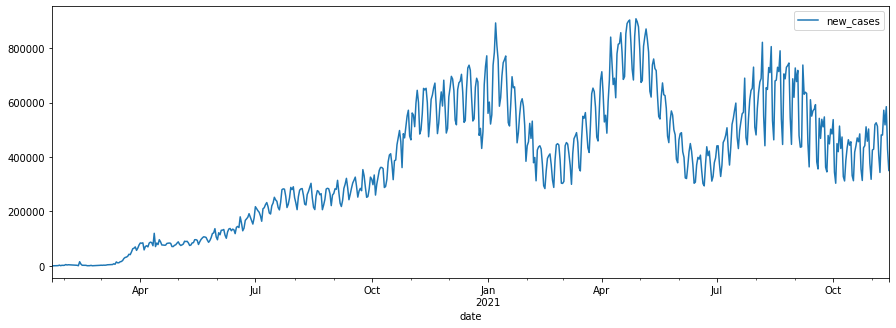

In [ ]:
time_series = df[df.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
time_series.plot(figsize=(15,5),logy=False)

Error measure used to evaluate your solution is Root Mean Square Log Error (RMSLE), square-root of
https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_log_error.html#sklearn.metrics.mean_squared_log_error.

In [ ]:
from sklearn.metrics import mean_squared_log_error
def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))

Maximum execution time in seconds and days to predict

In [ ]:
import time
max_prediction_time = 3*60
days_to_predict = 7

In [ ]:
from statsmodels.tsa.stattools import adfuller
print("ADF" , adfuller(time_series.iloc[:,0].values))

ADF (-2.3224072092967893, 0.1648430008323422, 15, 647, {'1%': -3.4404975024933813, '5%': -2.8660174956716795, '10%': -2.569154453750397}, 15209.237915355177)


Therefore time series is not stationary with 15% probability

In [ ]:
time_p = np.log(time_series)
time_p.replace([np.inf, -np.inf], np.nan, inplace=True)
time_p = time_p.dropna()
print("ADF" , adfuller(time_p.iloc[:,0].values))

ADF (-4.4879962039532195, 0.00020669734674675941, 19, 642, {'1%': -3.4405768522418607, '5%': -2.8660524488494903, '10%': -2.569173076930542}, -468.0238106881234)


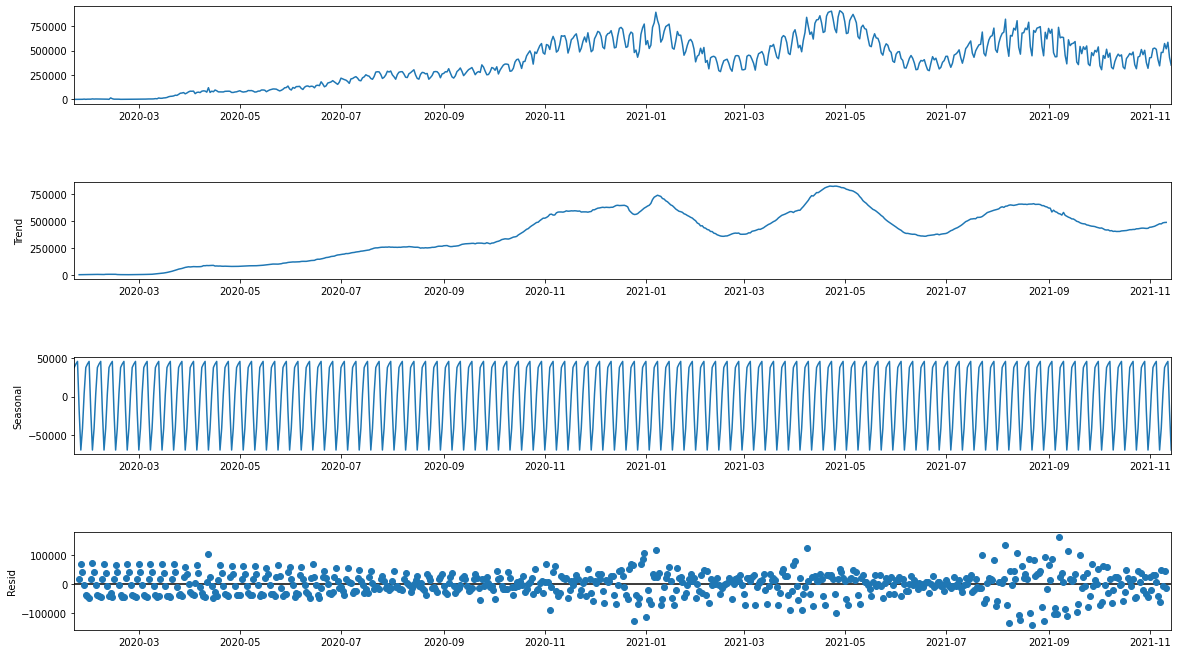

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
b = seasonal_decompose(time_series, model='additive')
c = b.plot()
c.set_figheight(10)
c.set_figwidth(20)

# My models

<span style="color:red">This is the main section which you should rewrite and expand significanlty providing/documenting your models tried and results with them.</span>

**Here you define your different prediction models. Each model should be in a function that takes the dataframe up to the training_end_date as input and outputs prediction of OWID_WRL new_cases for the following 7 days. The models should only use the data that they get as input! Training, possible hyperparameter optimization, and prediction should be done inside this function. The execution should take no longer than 3 minutes on Google Colab nachine with Tesla**

Give links to the sources of the models and the ideas!

Execution of this section should not take long (no training here, just definition of functions ;).

## 1. A simple persistency model

Returns the last week as the prediction for the next one.

In [ ]:
def get_last_week(input_data):
    # simply return the last 7 values of the relevant time series
    intput_time_series = input_data[input_data.iso_code=='OWID_WRL'].new_cases.values
    return intput_time_series[-7:]

## 2. PROPHET models

In [ ]:
def prophett(input_data):
  from prophet import Prophet
  intput_time_series = input_data[input_data.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
  intput_time_series = intput_time_series.reset_index()
  intput_time_series.rename(columns = {'date': 'ds','new_cases':'y'}, inplace = True)


  #Initializing Prophet model
  ml = Prophet()
  ml.fit(intput_time_series)
  future = ml.make_future_dataframe(periods=7)
  prediction = ml.predict(future[-7:])
  prediction.rename(columns = {'ds': 'date', 'yhat' : 'predictionvalues'}, inplace = True)
  prediction = prediction.set_index("date")
  final_df = prediction.iloc[:,-1:]
  return final_df.values



Weekly seasonal prophet

In [ ]:
def weekly_prophett(input_data):
  from prophet import Prophet
  intput_time_series = input_data[input_data.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
  intput_time_series = intput_time_series.reset_index()
  intput_time_series.rename(columns = {'date': 'ds','new_cases':'y'}, inplace = True)


  #Initializing Prophet model
  ml = Prophet(weekly_seasonality= 50)
  ml.fit(intput_time_series)
  future = ml.make_future_dataframe(periods=7)
  prediction = ml.predict(future[-7:])
  prediction.rename(columns = {'ds': 'date', 'yhat' : 'predictionvalues'}, inplace = True)
  prediction = prediction.set_index("date")
  final_df = prediction.iloc[:,-1:]
  return final_df.values

Daily Seasonality Prophet

In [ ]:
def daily_prophett(input_data):
  from prophet import Prophet
  intput_time_series = input_data[input_data.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
  intput_time_series = intput_time_series.reset_index()
  intput_time_series.rename(columns = {'date': 'ds','new_cases':'y'}, inplace = True)


  #Initializing Prophet model
  ml = Prophet(daily_seasonality= 50)
  ml.fit(intput_time_series)
  future = ml.make_future_dataframe(periods=7)
  prediction = ml.predict(future[-7:])
  prediction.rename(columns = {'ds': 'date', 'yhat' : 'predictionvalues'}, inplace = True)
  prediction = prediction.set_index("date")
  final_df = prediction.iloc[:,-1:]
  return final_df.values

## 3. Seasonal ARIMA model

Using daily seasonality

In [ ]:
def arimaa(input_data):
  intput_time_series = input_data[input_data.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
  prediction = pm.arima.auto_arima(intput_time_series,seasonal=True , m =7)
  return prediction.predict(7)

## 4. Autoregressive models

Daily seasonal component.

In [ ]:
def weekly_autoreg(input_data):
    # An autoregressive model with weekly seasonal component
    # preservind dates as index may be useful to some models
    intput_time_series = input_data[input_data.iso_code=='OWID_WRL'][['date','new_cases']].set_index('date')
    # construct the model and train
    model = AutoReg(intput_time_series, lags=7, seasonal=True, period=7 ).fit()
    # predict
    prediction = model.predict(start=len(intput_time_series),
        end=len(intput_time_series)+7-1, dynamic=False)
    return prediction.values

# Model validations and results

## Data split for experiments and validation

Using out of sample validation

Set the dates:

In [ ]:
from datetime import timedelta
validation_end_date = df.date.max() # you can change this, e.g. to df.date.max()
# testing end date will be 2021.11.22 in the end
validation_start_date = validation_end_date - timedelta(days=days_to_predict-1)
training_end_date = validation_end_date - timedelta(days=days_to_predict) # will be 2021.11.15 in the end - the deadline
print((training_end_date, validation_start_date, validation_end_date))
validation_date_range = pd.date_range(validation_start_date, periods=days_to_predict)

(Timestamp('2021-11-07 00:00:00'), Timestamp('2021-11-08 00:00:00'), Timestamp('2021-11-14 00:00:00'))


Generate input and target for validation:

In [ ]:
input_data = df[df.date <= training_end_date]
target_output = df[df.date.isin( validation_date_range ) & (df.iso_code=='OWID_WRL')].new_cases.values
target_output

array([481288., 480717., 572076., 518160., 585111., 428588., 350606.])

## Validate all models

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import logging
logging.getLogger('prophet').setLevel(logging.WARNING)


model_names = {weekly_autoreg, prophett,get_last_week, weekly_prophett,arimaa,daily_prophett}
for name in model_names:

  model_to_validate = name

  start_time = time.time()
  predicted_time_series = model_to_validate(input_data)
  end_time = time.time()
  elapsed_time = end_time - start_time
  prediction_error = RMSLE(target_output, predicted_time_series)
  print('%s prediction error: %.8f, time: %.2fs (max %is)'
      %(model_to_validate.__name__, prediction_error, elapsed_time, max_prediction_time))
  assert elapsed_time <= max_prediction_time, 'Training is too long!'

weekly_autoreg prediction error: 0.10815085, time: 0.03s (max 180s)
weekly_prophett prediction error: 0.09319378, time: 2.58s (max 180s)
arimaa prediction error: 0.05550455, time: 72.79s (max 180s)
daily_prophett prediction error: 0.09313657, time: 2.55s (max 180s)
get_last_week prediction error: 0.09072434, time: 0.01s (max 180s)
prophett prediction error: 0.09240721, time: 1.87s (max 180s)


## Model validation results

The results here are from a simple out-of-sample validation on dates 2021-11-09 to 2021-11-14, using all the previous data as input.


| Model, variation | Validation RMSLE | Execution time, s |
|-------|---------------|---------------|
| prophett  |    0.09240721 | 1.87        |
| daily_prophett |    0.09313657   | 2.56        |
| weekly_prophett| 0.09319378 | 2.57        |
| get_last_week |    0.09072434   | 0.01        |
| weekly_autoreg, 7 lags |    0.10815085   | 0.02        |
| arimaa |    **0.05550455**   | 72.86     |



We see that all except arimaa,models are very fast, the time is used mostly since its an auto arima model which tries out all lower order combination of autoregressive and moving average terms as well as for seasonal terms.

The most accurate of the models validated is seasonal arima with daily seasonailty component. I choose it as my best model.

# My best model

I choose the autoregressive model with 7 lags and a weekly seasonal component as my best, to compete in the "model olympics".


In [ ]:
my_best_model = arimaa

# Testing

<span style="color:red">Do not edit beyound this point!</span>

This is a dummy testing routine of `my_best_model`, similar to what will be done after your submission. If your `my_best_model` doesn't work, fix it, not the code here (it will be replaced).

In [ ]:
import numpy as np
import pandas as pd
from datetime import timedelta
import time
from sklearn.metrics import mean_squared_log_error

def RMSLE(y_true, y_pred):
    return np.sqrt(mean_squared_log_error(y_true, y_pred))


max_prediction_time = 3*60
days_to_predict = 7

url = "owid-covid-data.csv"
df = pd.read_csv(url, parse_dates=[3])

testing_end_date = pd.Timestamp(2021,10,25) # you can change this, e.g. to df.date.max()
# testing end date will be 2021.11.22 in the end
testing_start_date = testing_end_date - timedelta(days=days_to_predict-1)
testing_input_end_date = testing_end_date - timedelta(days=days_to_predict) # will be 2021.11.15 in the end - the deadline
print((testing_input_end_date, testing_start_date, testing_end_date))
testing_date_range = pd.date_range(testing_start_date, periods=days_to_predict)

test_input_data = df[df.date <= testing_input_end_date]
test_target_output = df[df.date.isin( testing_date_range ) & (df.iso_code=='OWID_WRL')].new_cases.values

start_time = time.time()
test_predicted_output = my_best_model(test_input_data)
end_time = time.time()
elapsed_time = end_time - start_time

prediction_error = RMSLE(test_target_output, test_predicted_output)
print('Test prediction error: %.8f, time: %.2fs (max %is)'
    %(prediction_error, elapsed_time, max_prediction_time))
assert elapsed_time <= max_prediction_time, 'Training is too long!'


FileNotFoundError: ignored

## Information on the hardware

Only relavant if execution time is in question: then it is tested on Colab Tesla K80 node.

In [ ]:
import os
osname = os.name
print(osname)
if osname == 'posix':
    f = os.popen('nvidia-smi')
    print(f.read())

    f = os.popen('lscpu')
    print(f.read())
elif osname == 'nt':
    # from https://winaero.com/get-cpu-information-via-command-prompt-in-windows-10/
    f = os.popen('wmic cpu get caption, deviceid, name, numberofcores, maxclockspeed, status')
    print(f.read())

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')